# Accessing the Netzschleuder Repository

## Motivation and Learning Objectives

Access to a large number of graphs with different topological characteristics and from different domains is crucial for the development and evaluation of graph learning methods. Tousands of graph data sets are available scattered throughout the web, possibly using different data formats and with missing information on their actual origin. Addressing this issue the [Netschleuder Online Repository](https://networks.skewed.de/) by Tiago Peixoto provides a single repository of graphs in a single format, including descriptions, citations, and node-/edge- or graph-level meta-data. To facilitate the development of graph learning techniques, pathpyG provides a feature that allows to directly read networks from the netzschleuder repository via an API.

In this brief unit, we will learn how we can retrieve network records and graph data from the netzschleuder repository. We will further demonstrate how we can conveniently apply a Graph Neural Network to predict node-level categories contained in the meta-data.

We first need to import a few modules.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.decomposition import TruncatedSVD

import torch
from torch.nn import Linear, ReLU, Sigmoid, Parameter

import torch_geometric
from torch_geometric.nn import Sequential, GCNConv, SimpleConv, MessagePassing

import pathpyG as pp

pp.config['torch']['device'] = 'cpu'

## Reading graphs from the netzschleuder repository

In the `pathpy.io` module, there is a function that allows to read graph data from the API. 

We can read a given networks from the netzschleuder database using its record name. Just browse the [Netschleuder Online Repository](https://networks.skewed.de/) to find the record names. In the following, we use a graph capturing co-purchase relationships between political books.



In [2]:
g = pp.io.read_netzschleuder_network('polbooks')
print(g)

Graph with 105 nodes and 441 edges

Node attributes
	node_label		<class 'list'>
	node__pos		<class 'list'>
	node_value		<class 'list'>

Graph attributes
	tags		<class 'list'>
	node_id		<class 'list'>
	num_nodes		<class 'int'>
	name		<class 'str'>
	directed		<class 'float'>
	description		<class 'str'>
	url		<class 'str'>
	citation		<class 'str'>



If we print the resulting `Graph` instance, we find that the meta information at the node- and grah-level are automatically retrieved and added to the graph.

Let us read the famous karate club network. The record `karate club` actually contains two networks with labels `77` and `78`, which refer to two different versions of the graph data. If multiple graph data sets exist in the same record, we need to specify the name of the graph as second argument.

In [3]:
g = pp.io.read_netzschleuder_network('karate', '77')
print(g)

Graph with 34 nodes and 77 edges

Node attributes
	node_name		<class 'list'>
	node_groups		<class 'list'>
	node__pos		<class 'list'>

Graph attributes
	tags		<class 'list'>
	node_id		<class 'list'>
	num_nodes		<class 'int'>
	name		<class 'str'>
	description		<class 'str'>
	url		<class 'str'>
	citation		<class 'str'>



In [5]:
pp.plot(g);

We see that the nodes actually contain a `node_group` property, which maps the nodes to two groups. Those groups are often used as `ground truth` for communities in this simple illustrative graph. We will instead use it as ground truth categorical node label for a node classification experiment based on a Graph Neural Network.

In [6]:
print(g['node_groups'])

[[1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [1], [1], [1], [1], [2], [2], [1], [1], [2], [1], [2], [1], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2]]


We can plot categorical labels by passing them as node colors in the pathpy plot function.

In [7]:
pp.plot(g, node_color = [g['node_groups',v][0] for v in g.nodes])

For convenience, let us shift the group labels to binary values 0 and 1: 

In [8]:
g['node_groups'] = torch.tensor(g['node_groups']).float()
g['node_groups'] -= 1
print(g['node_groups'])

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])


## Applying Graph Neural Networks to Netzschleuder Data

We can retrieve a pytorch geometric data object that contains this information.

In [9]:
print(g.data)

Data(edge_index=[2, 77], num_nodes=34, node_id=[0], node_name=[34], node_groups=[34, 1], node__pos=[34], name='karate (77)', description='Network of friendships among members of a university karate club. Includes metadata for faction membership after a social partition. Note: there are two versions of this network, one with 77 edges and one with 78, due to an ambiguous typo in the original study. (The most commonly used is the one with 78 edges.)[^icon]
[^icon]: Description obtained from the [ICON](https://icon.colorado.edu) project.', citation='['W. W. Zachary, "An information flow model for conflict and fission in small groups." Journal of Anthropological Research 33, 452-473 (1977)., https://doi.org/10.1086/jar.33.4.3629752']', url='https://aaronclauset.github.io/datacode.htm', tags=[3])


Let's use a one-hot encoding of nodes as a simple feature `x`, and let's use the node groups as target label `y`. 

In [10]:
data = g.data
g.add_node_ohe('node_feature')
data['x'] = data['node_feature']
data['y'] = data['node_groups']

We can now apply a GCN to the Karate club network:

In [11]:
model = Sequential('node_ohe, edge_index', [
    (GCNConv(in_channels=data.num_node_features, out_channels=8), 'node_ohe, edge_index -> node_ohe'),
    ReLU(inplace=True),
    (GCNConv(in_channels=8, out_channels=1), 'node_ohe, edge_index -> node_ohe'),
    Sigmoid(),
])
model.to(pp.config['torch']['device'])

Sequential(
  (0) - GCNConv(34, 8): node_ohe, edge_index -> node_ohe
  (1) - ReLU(inplace=True): node_ohe -> node_ohe
  (2) - GCNConv(8, 1): node_ohe, edge_index -> node_ohe
  (3) - Sigmoid(): node_ohe -> node_ohe
)

We next apply a `RandomNodeSplit` transformation to split the nodes in a training and test set.

In [12]:
transform = torch_geometric.transforms.RandomNodeSplit(split='train_rest', num_val=0.5, num_test=0)
data = transform(data)

We then train our model for 1000 epochs on the training set.

In [13]:
epochs = 1000

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
losses = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = torch.nn.functional.binary_cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    losses.append(loss.cpu().detach().numpy())

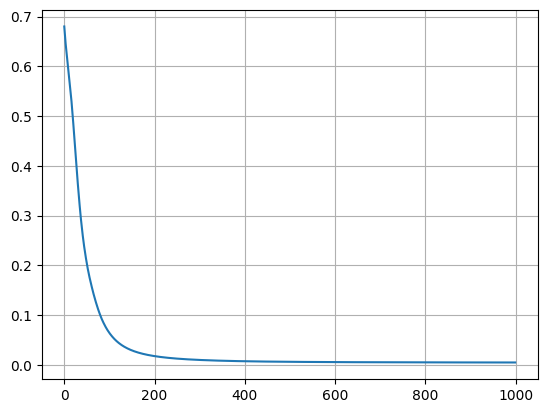

In [14]:
plt.plot(range(epochs), losses)
plt.grid()

We evaluate the model in the test set and calculate the adjusted mutual information for the ground truth.

In [15]:
model.eval()
predicted_groups = model(data.x, data.edge_index).round().long()
metrics.adjusted_mutual_info_score(data.y[data.test_mask].squeeze().cpu().numpy(), predicted_groups[data.test_mask].squeeze().cpu().numpy())

1.0

We visualize node representations learned by the model. The training nodes are colored, while test nodes are greyed out.

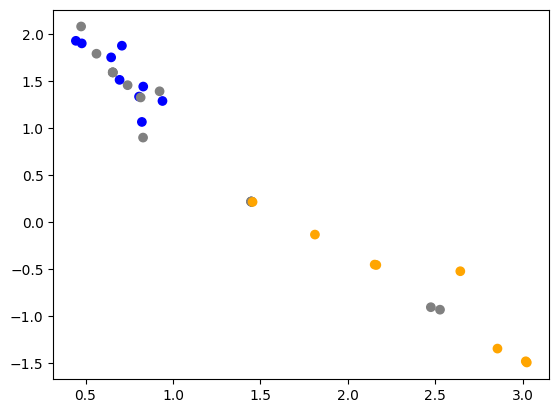

In [16]:
# get activations in first-layer
embedding = model[0].forward(data.x, data.edge_index)

# dimensionality reduction
svd = TruncatedSVD()
low_dim = svd.fit_transform(embedding.cpu().detach().numpy())

# plot with colors corresponding to groups in validation set
colors = {}
for v in range(g.N):
    if data.val_mask[v]:
        colors[v] = 'grey'
    else:
        if data.y[v].item() == 0.0:
            colors[v] = 'blue'
        else:
            colors[v] = 'orange'

plt.scatter(low_dim[:,0], low_dim[:,1], c=colors.values());

This simple code gives you thousands of networks with various meta information at your fingertips, to wich you can directly apply graph learning models provided in pyG, or deep graoh learning architectures defined by yourself. 